In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def generate_data(n_samples=100):
    X = torch.linspace(-3, 3, n_samples).reshape(-1, 1)
    y = X**3 + 2*X**2 - 3*X + 1 + torch.randn_like(X) * 0.2
    return X, y

In [3]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.network(x)

In [ ]:
def train_vanilla_gd(model, X, y, learning_rate=0.01, epochs=1000):
    losses = []
    
    for epoch in range(epochs):

        y_pred = model(X)
        loss = torch.mean((y_pred - y)**2)
        losses.append(loss.item())
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
        
        loss.backward()
        
        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad
                param.grad.zero_()
            
    
    return losses

In [7]:
X, y = generate_data()

model_gd = NN()
losses_gd = train_vanilla_gd(model_gd, X, y)

Epoch [100/1000], Loss: 7.7382
Epoch [200/1000], Loss: 4.6364
Epoch [300/1000], Loss: 3.4425
Epoch [400/1000], Loss: 2.7999
Epoch [500/1000], Loss: 2.2812
Epoch [600/1000], Loss: 1.8261
Epoch [700/1000], Loss: 1.6555
Epoch [800/1000], Loss: 1.3813
Epoch [900/1000], Loss: 1.3358
Epoch [1000/1000], Loss: 1.0862


In [ ]:
def train_adam(model, X, y, learning_rate=0.01, epochs=1000, beta1=0.9, beta2=0.999, epsilon=1e-8):
    losses = []
    m = {}
    v = {}
    for name, param in model.named_parameters():
        m[name] = torch.zeros_like(param)
        v[name] = torch.zeros_like(param)
    
    for epoch in range(epochs):
        y_pred = model(X)
        loss = torch.mean((y_pred - y)**2)
        losses.append(loss.item())
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
        

        loss.backward()
        
        # Adam update
        with torch.no_grad():
            for name, param in model.named_parameters():
                grad = param.grad
                
                # Update moment estimates
                m[name] = beta1 * m[name] + (1 - beta1) * grad
                v[name] = beta2 * v[name] + (1 - beta2) * (grad**2)
                
                # Bias correction
                m_hat = m[name] / (1 - beta1**(epoch + 1))
                v_hat = v[name] / (1 - beta2**(epoch + 1))
                
                # Update parameters
                param -= learning_rate * m_hat / (torch.sqrt(v_hat) + epsilon)
                param.grad.zero_()
    
    return losses

In [9]:
class NN_ADAM(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.network(x)

In [10]:
model_adam = NN_ADAM()
losses_adam = train_adam(model_adam, X, y)

Epoch [100/1000], Loss: 14.4850
Epoch [200/1000], Loss: 1.3176
Epoch [300/1000], Loss: 0.3471
Epoch [400/1000], Loss: 0.2054
Epoch [500/1000], Loss: 0.1505
Epoch [600/1000], Loss: 0.1290
Epoch [700/1000], Loss: 0.1208
Epoch [800/1000], Loss: 0.1130
Epoch [900/1000], Loss: 0.1076
Epoch [1000/1000], Loss: 0.1057


In [12]:
class NN_TORCH_ADAM(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.network(x)

In [16]:
model_torch_adam = NN_TORCH_ADAM()
optimizer = torch.optim.Adam(model_torch_adam.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-8)
losses_torch_adam = []

epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model_torch_adam(X)
    loss = torch.mean((y_pred - y)**2)
    losses_torch_adam.append(loss.item())
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
        
    loss.backward()
    optimizer.step()

Epoch [100/1000], Loss: 10.4759
Epoch [200/1000], Loss: 0.5121
Epoch [300/1000], Loss: 0.2009
Epoch [400/1000], Loss: 0.1080
Epoch [500/1000], Loss: 0.0762
Epoch [600/1000], Loss: 0.0646
Epoch [700/1000], Loss: 0.0568
Epoch [800/1000], Loss: 0.0517
Epoch [900/1000], Loss: 0.0487
Epoch [1000/1000], Loss: 0.0480


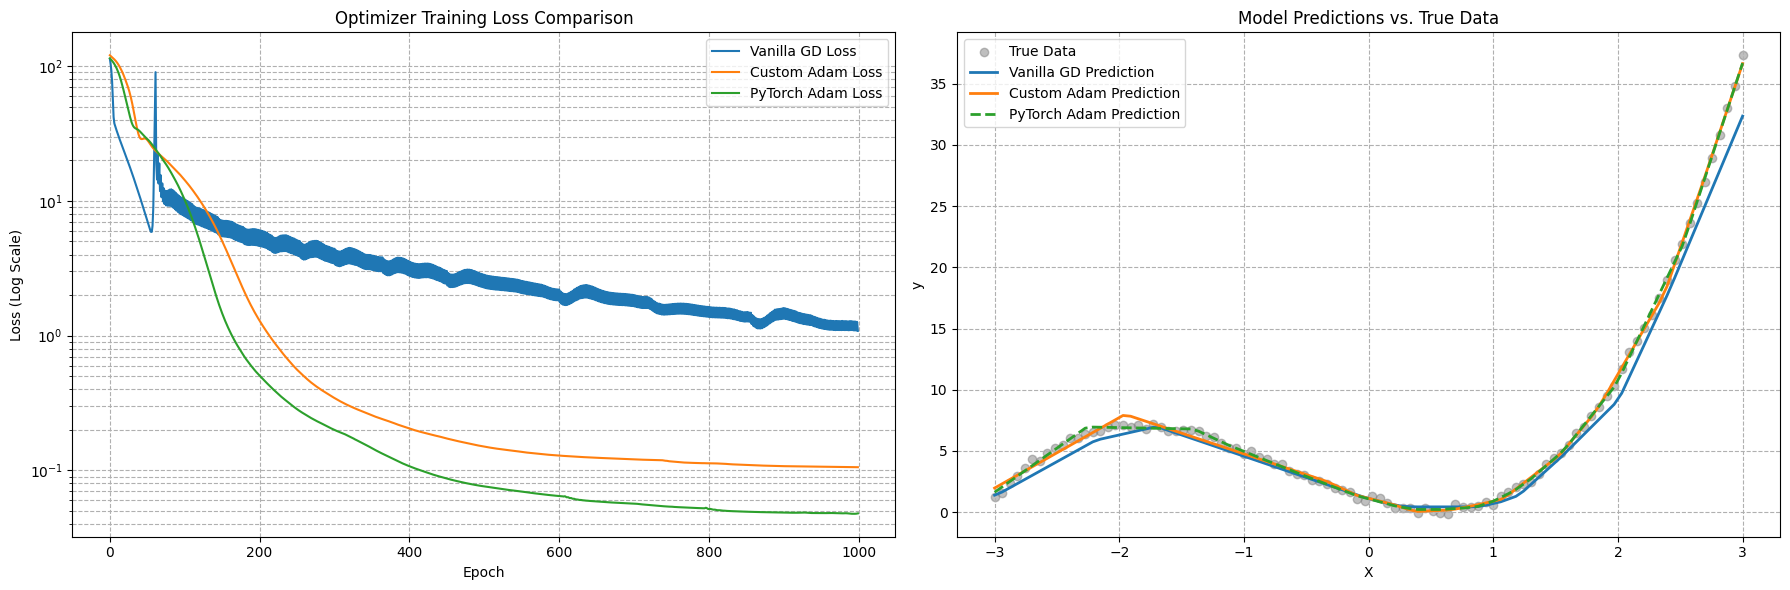

In [ ]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(losses_gd, label='Vanilla GD Loss')
plt.plot(losses_adam, label='Custom Adam Loss')
plt.plot(losses_torch_adam, label='PyTorch Adam Loss')
plt.yscale('log')
plt.title('Optimizer Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss (Log Scale)')
plt.legend()
plt.grid(True, which="both", ls="--")


plt.subplot(1, 2, 2)
with torch.no_grad():
    y_pred_gd = model_gd(X)
    y_pred_adam = model_adam(X)
    y_pred_torch_adam = model_torch_adam(X)

plt.scatter(X.numpy(), y.numpy(), label='True Data', alpha=0.5, color='gray')
plt.plot(X.numpy(), y_pred_gd.numpy(), label='Vanilla GD Prediction', linewidth=2)
plt.plot(X.numpy(), y_pred_adam.numpy(), label='Custom Adam Prediction', linewidth=2)
plt.plot(X.numpy(), y_pred_torch_adam.numpy(), label='PyTorch Adam Prediction', linewidth=2, linestyle='--')
plt.title('Model Predictions vs. True Data')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid(True, ls="--")

plt.tight_layout()
plt.show()

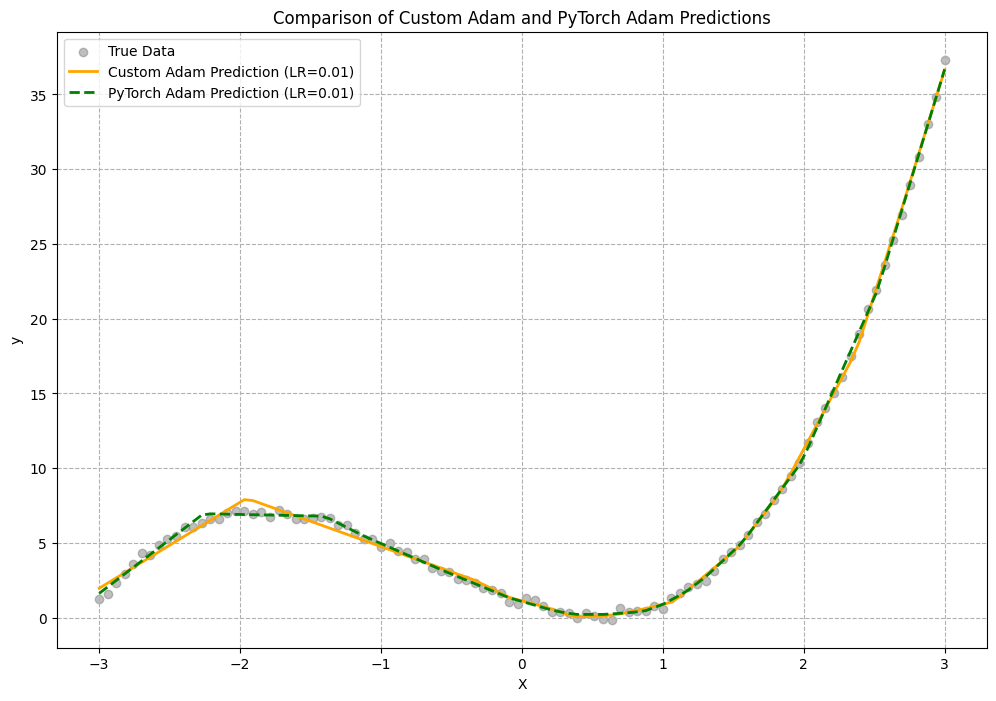

In [ ]:
plt.figure(figsize=(12, 8))

plt.scatter(X.numpy(), y.numpy(), label='True Data', alpha=0.5, color='gray')
plt.plot(X.numpy(), y_pred_adam.numpy(), label='Custom Adam Prediction (LR=0.01)', linewidth=2, color='orange')
plt.plot(X.numpy(), y_pred_torch_adam.numpy(), label='PyTorch Adam Prediction (LR=0.01)', linewidth=2, linestyle='--', color='green')

plt.title('Comparison of Custom Adam and PyTorch Adam Predictions')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid(True, which="both", ls="--")

plt.show()